## Load libraries


In [1]:
import numpy as np 
import collections
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from skimage.io import imread
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Remove warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/adejuwon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## LOAD DATASET

In [2]:
all_scans_df = pd.DataFrame(dict(path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png'))))
all_scans_df['TrainSplit'] = all_scans_df['path'].map(lambda x: x.split('/')[-5])
all_scans_df['Region'] = all_scans_df['path'].map(lambda x: x.split('/')[2])
all_scans_df['Patient'] = all_scans_df['path'].map(lambda x: x.split('/')[-3])
all_scans_df['FolderId'] = all_scans_df['path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])
all_scans_df['Labels'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[-1] )
all_scans_df.sample(20)

,path,TrainSplit,Region,Patient,FolderId,Study,Labels
8379,MURA-v1.1/train/XR_HAND/patient10438/study1_ne...,train,XR_HAND,patient10438,study1_negative,study1,negative
16136,MURA-v1.1/train/XR_ELBOW/patient05089/study1_p...,train,XR_ELBOW,patient05089,study1_positive,study1,positive
30721,MURA-v1.1/train/XR_WRIST/patient08731/study1_n...,train,XR_WRIST,patient08731,study1_negative,study1,negative
14107,MURA-v1.1/train/XR_FINGER/patient03933/study1_...,train,XR_FINGER,patient03933,study1_negative,study1,negative
39196,MURA-v1.1/train/XR_FOREARM/patient05535/study1...,train,XR_FOREARM,patient05535,study1_negative,study1,negative
2758,MURA-v1.1/valid/XR_WRIST/patient11292/study1_n...,valid,XR_WRIST,patient11292,study1_negative,study1,negative
32877,MURA-v1.1/train/XR_WRIST/patient06556/study1_p...,train,XR_WRIST,patient06556,study1_positive,study1,positive
38975,MURA-v1.1/train/XR_FOREARM/patient09574/study1...,train,XR_FOREARM,patient09574,study1_negative,study1,negative
2732,MURA-v1.1/valid/XR_WRIST/patient11203/study1_p...,valid,XR_WRIST,patient11203,study1_positive,study1,positive
27351,MURA-v1.1/train/XR_SHOULDER/patient01205/study...,train,XR_SHOULDER,patient01205,study1_positive,study1,positive


## Showing Sample of X-Ray

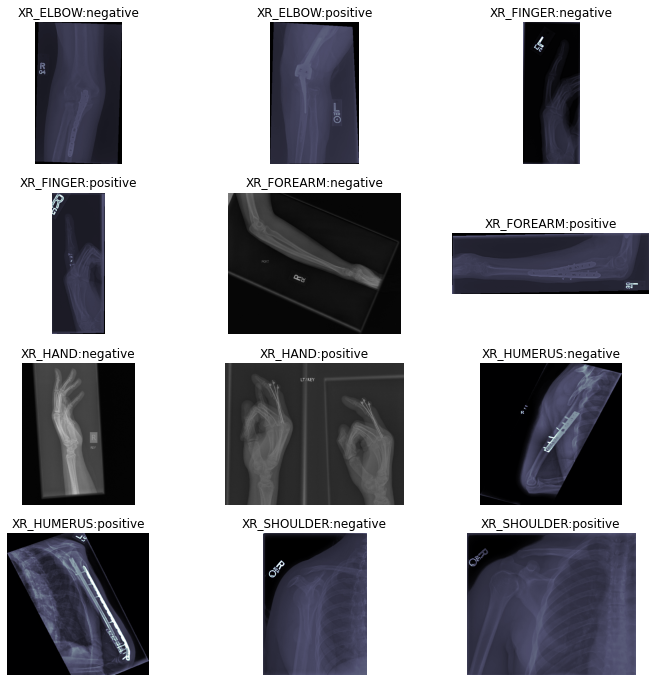

In [3]:
sub_df = all_scans_df.groupby(['Region', 'Labels']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Region}:{Labels}'.format(**c_row))
fig.savefig('samples.png', dpi = 300)


## All upper extremity body parts divided into training and validation dataset


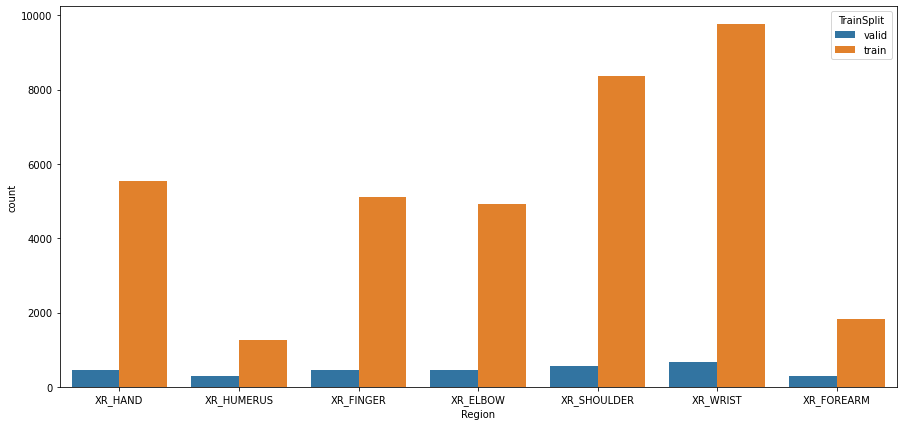

In [4]:
plt.figure(figsize=(15,7))
sns.countplot(data=all_scans_df,x='Region',hue='TrainSplit')

## Training and Validation dataset:

a. Negative (normal X-rays. These are X-rays that have no problems associated with them).
b. Positive (abnormal X-rays. These are X-rays that have problems associated with them).

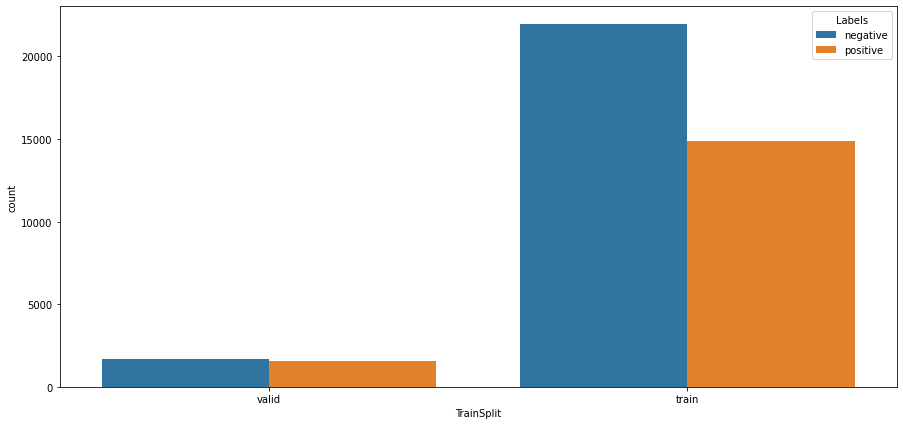

In [5]:
plt.figure(figsize=(15,7))
sns.countplot(data=all_scans_df,x='TrainSplit',hue='Labels')

## Questions


## 1. What is the distribution of X-rays versus the number of patients in each dataset?



In [6]:
data_cat= ['train', 'valid']
Body_Part = list(os.walk('/Users/adejuwon/MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets

patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in Body_Part:
        patients = list(os.walk('/Users/adejuwon/MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

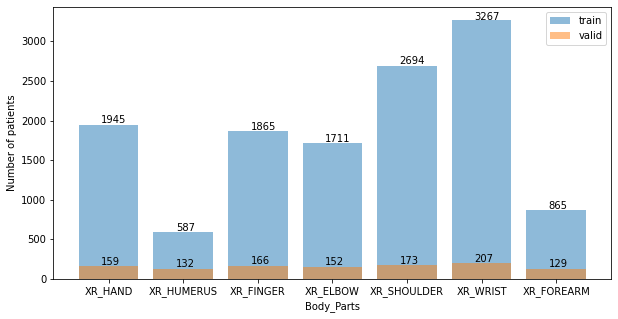

In [7]:
# plot the patient counts per study type 

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(Body_Part))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, Body_Part)

plt.xlabel('Body_Parts')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()



## The bar chart shows most Xrays were conducted on patients with wrist incidents for both the training and validation dataset

## 2. What is the distribution of the abnormal(1 class) and Normal (0) X-rays in our dataset?


In [10]:
PATH="MURA-v1.1/"

In [11]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths.csv')
train_labels=pd.read_csv(PATH+'train_labeled_studies.csv')
valid_imgs_path=pd.read_csv(PATH+'valid_image_paths.csv')
valid_labels=pd.read_csv(PATH+'valid_labeled_studies.csv')

In [12]:
train_labels['Body_Part']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study_Type']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])
valid_labels['Body_Part']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
valid_labels['Study_Type']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])

In [13]:
train_labels['Label'].value_counts()

0    8280
1    5177
Name: Label, dtype: int64

In [14]:
train_labels['Label'].value_counts(normalize=True)


0    0.615293
1    0.384707
Name: Label, dtype: float64

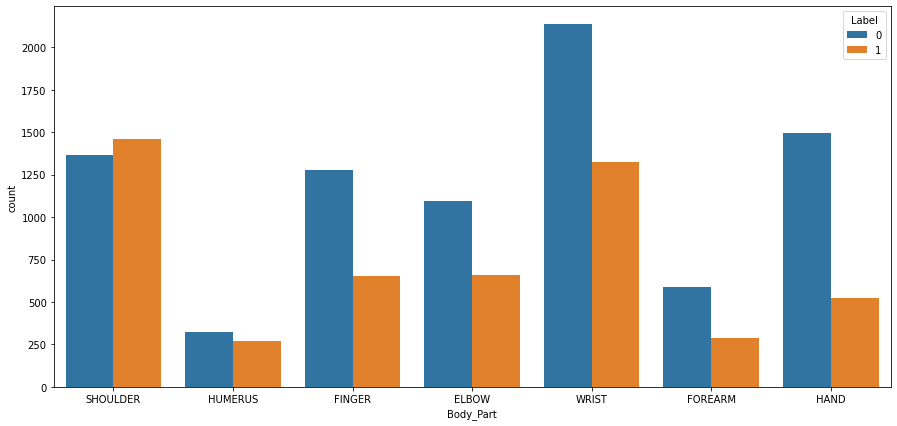

In [15]:
plt.figure(figsize=(15,7))
sns.countplot(data=train_labels,x='Body_Part',hue='Label')

**Sorting data out into positive and negative for Validation Data ( Normal and Abnormal Xrays) :Positive = 0 and Negative =1

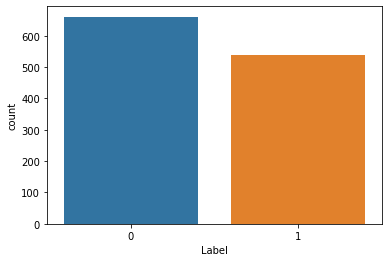

In [16]:
sns.countplot(valid_labels['Label'])

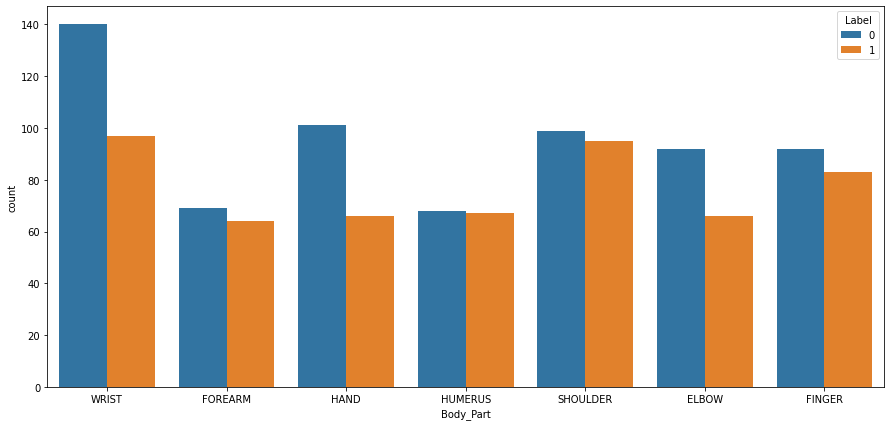

In [17]:
plt.figure(figsize=(15,7))
sns.countplot(data=valid_labels,x='Body_Part',hue='Label')

Sample of Images

In [18]:

PATH="MURA-v1.1/"

In [19]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths.csv')
train_labels=pd.read_csv(PATH+'train_labeled_studies.csv')
valid_imgs_path=pd.read_csv(PATH+'valid_image_paths.csv')
valid_labels=pd.read_csv(PATH+'valid_labeled_studies.csv')

In [20]:
train_imgs_path.head()

,Img_Path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [21]:

train_imgs_path.shape

(36808, 1)

In [22]:
valid_labels.head()

,Img_Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [23]:

train_labels.shape

(13457, 2)

In [24]:

valid_imgs_path.head()

,Image_Path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [25]:
valid_imgs_path.shape

(3197, 1)

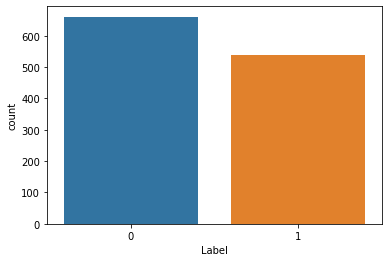

In [26]:
sns.countplot(valid_labels['Label'])

In [27]:

train_labels['Body_Part']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study_Type']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])
valid_labels['Body_Part']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
valid_labels['Study_Type']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])

In [28]:
train_labels.head()

,Img_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,SHOULDER,study1


In [29]:
valid_labels.head()

,Img_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,study1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,study2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,study3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,study1


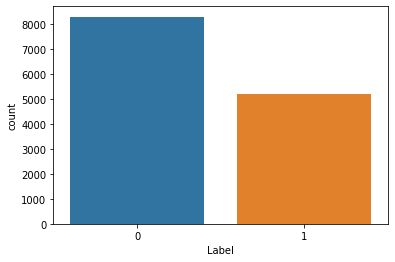

In [30]:
sns.countplot(train_labels['Label'])

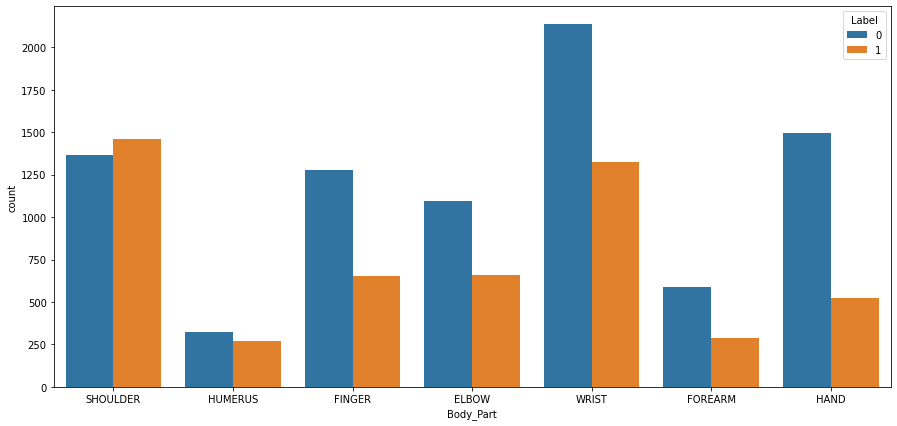

In [31]:
plt.figure(figsize=(15,7))
sns.countplot(data=train_labels,x='Body_Part',hue='Label')

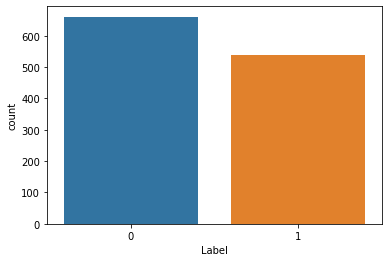

In [32]:
sns.countplot(valid_labels['Label'])


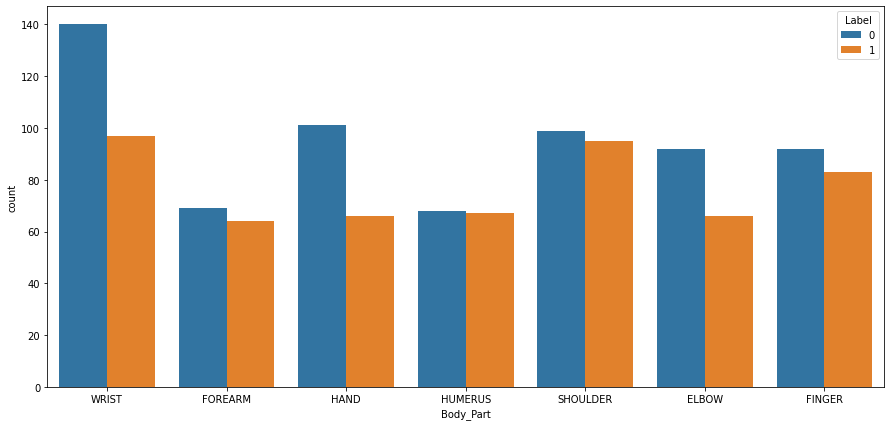

In [33]:
plt.figure(figsize=(15,7))
sns.countplot(data=valid_labels,x='Body_Part',hue='Label')

## Third question
## Which upper extremity part had most X-ray views?

In [8]:
# let's find out number of studies per study_type
study_count = {} # to store study counts for each study type 
for study_type in Body_Part:
    BASE_DIR ='/Users/adejuwon/MURA-v1.1/train/%s/'  % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1

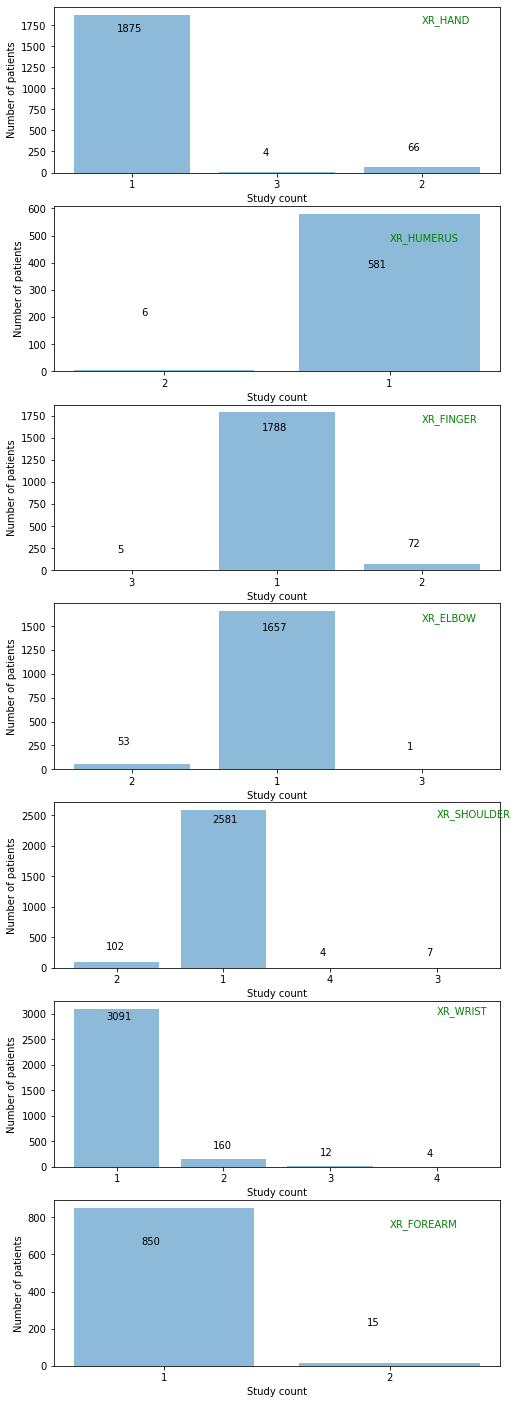

In [34]:
# plot the study count vs number of patients per study type data 
fig = plt.figure(figsize=(8, 25))
for i, study_type in enumerate(study_count):
    ax = fig.add_subplot(7, 1, i+1)
    study = study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 200, str(v))
    ax.text(i, m - 100, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
plt.show()